In [47]:
#question2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(r'fsp_case_31_BSD.csv',index_col=0,header=[0,1])

In [2]:
last10 = df['ret'].iloc[:, -10:]

In [3]:
last10

cmp_id,G_TUIGR,G_UNANA,G_UPMFH,G_VIEFP,G_VIVFP,G_VLVY,G_VOD,G_VW,G_WKLNA,G_WPPLN
2017-01-02,0.028915,0.003451,0.005998,0.010820,0.002216,0.001880,0.000000,0.030347,0.010604,0.000000
2017-01-03,-0.003285,-0.006752,0.004685,-0.011927,0.000829,0.005629,0.012760,0.020227,-0.006468,0.004956
2017-01-04,0.001099,0.001539,-0.008478,-0.003404,0.005522,0.004664,0.016304,-0.011826,-0.004051,-0.007124
2017-01-05,0.003658,0.001409,0.002993,-0.018945,0.001647,-0.001857,0.018230,0.008448,0.013219,0.009934
2017-01-06,-0.008382,-0.004348,0.000000,-0.010130,0.004934,0.000000,0.009071,-0.004537,-0.003584,0.005464
...,...,...,...,...,...,...,...,...,...,...
2018-12-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-12-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-12-27,-0.022882,-0.010322,0.000908,-0.027516,-0.001429,-0.008703,-0.019289,-0.057439,-0.013693,-0.023294
2018-12-28,0.010682,0.008279,0.004079,0.015719,0.002384,0.017998,0.020196,0.021292,0.016660,0.027463


In [14]:
train_set = last10.iloc[0:261]
test_set = last10.iloc[261:]

In [43]:
def get_w_opt(df): 
    C = df.cov().values
    m, n = C.shape
    A = np.insert(C, n, -1, axis=1)
    A = np.insert(A, m, 1, axis=0)
    A[-1, -1] = 0

    m, n = A.shape
    y = np.zeros(m)
    y[-1] = 1

    x = np.linalg.solve(A, y)
    w_opt = x[:-1]
    lambd = x[-1]
    return w_opt, lambd

def get_variance(df, w):
    C = df.cov().values
    return np.dot(np.dot(w.T, C), w)

def get_w_equal(df):
    _, m = df.shape
    w_equal = np.ones(m) * 1 / m
    variance = get_variance(df, w_equal)
    return w_equal, variance

def get_ret(df, w):
    ret = (df * w).sum(axis=1)
    var = get_variance(df, w)
    ret_opt = pd.DataFrame(ret, columns=['Optimal Return'])
    
    w_equal, var_equal = get_w_equal(df)
    ret = (df * w_equal).sum(axis=1)
    equal_ret = pd.DataFrame(ret, columns=['Equal-weighted Return'])
    return pd.concat([equal_ret, ret_opt], axis=1), var, var_equal

In [49]:
w_opt, var_train_opt= get_w_opt(train_set)
ret_test_opt, var_test_opt, var_test_equal = get_ret(test_set, w_opt)

In [50]:
pd.DataFrame([var_train_opt,var_test_opt,var_test_equal], columns = ["Variance"], index = ["Optimal Train", "Optimal Test", "Equal-weighted Test"]).transpose()

,Optimal Train,Optimal Test,Equal-weighted Test
Variance,0.000029,0.000082,0.00008


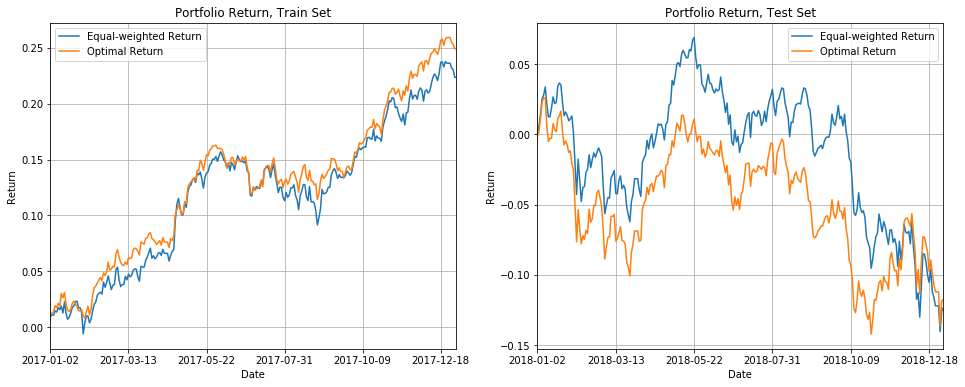

In [61]:
ret_train_opt, _, _ = get_ret(train_set, w_opt)

fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ret_train_opt.cumsum().plot(ax=ax1, title='Portfolio Return, Train Set')
ax1.set_xlabel('Date')
ax1.set_ylabel('Return')
ax1.grid()

ret_test_opt.cumsum().plot(ax=ax2, title='Portfolio Return, Test Set')
ax2.set_xlabel('Date')
ax2.set_ylabel('Return')
ax2.grid()

plt.savefig("images//different_w")

In [91]:
#question3
def get_adaptive_w_opt(df, window=22):
    w_list = []
    var_list = []
    ret = {}
    for i in range(0, df.shape[0] - window + 1):
        w_opt, var_opt = get_w_opt(df.iloc[ i : i + window + 1])
        w_list.append(w_opt)
        var_list.append(var_opt)
        temp_return = (df.iloc[i + window - 1] * w_opt).sum()
        ret[df.index[i + window - 1]] = temp_return
    
    ret = pd.DataFrame.from_dict(ret, orient='index')
    ret.index = pd.to_datetime(ret.index)
    ret.columns = ['Return']
    return ret, np.array(w_list), np.array(var_list)

def get_adaptive_w_opt_2(df, window=22):
    w_list = []
    var_list = []
    ret = {}
    for i in range(0, df.shape[0] - window):
        w_opt, var_opt = get_w_opt(df.iloc[ i : i + window + 1])
        w_list.append(w_opt)
        var_list.append(var_opt)
        temp_return = (df.iloc[i + window] * w_opt).sum()
        ret[df.index[i + window]] = temp_return
    
    ret = pd.DataFrame.from_dict(ret, orient='index')
    ret.index = pd.to_datetime(ret.index)
    ret.columns = ['Return']
    return ret, np.array(w_list), np.array(var_list)
    
ret_adapt, w_adapt, var_adapt = get_adaptive_w_opt(last10)
a,b,c = get_adaptive_w_opt_2(last10)

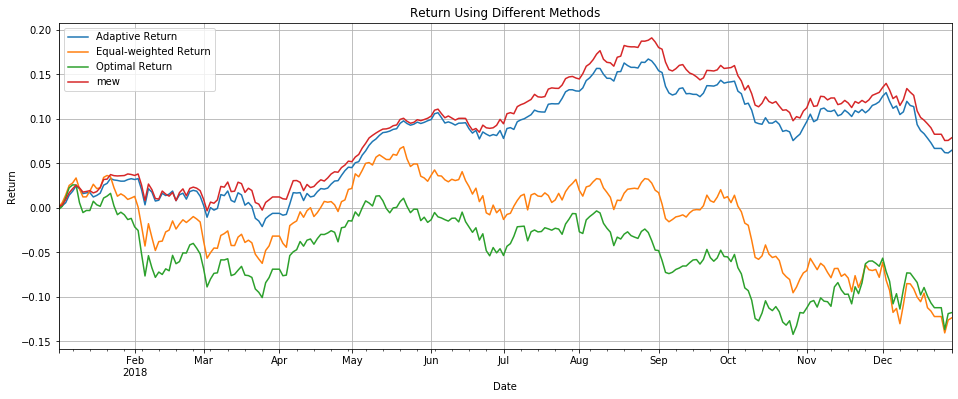

In [98]:
all_return = pd.concat([ret_adapt.loc['2018-01-02':], ret_test_opt, a.loc['2018-01-02':]], axis=1)
all_return.columns = ['Adaptive Return', 'Equal-weighted Return', 'Optimal Return', "mew"]

all_return.cumsum().plot(title='Return Using Different Methods', figsize = (16,6))
plt.xlabel('Date')
plt.ylabel("Return")
plt.grid()
plt.savefig("images//Return Using Different Strategies")

In [96]:
all_return.describe()

,Adaptive Return,Equal-weighted Return,Optimal Return,mew
count,260.000000,260.000000,260.000000,260.000000
mean,0.000249,-0.000475,-0.000452,0.000303
std,0.005695,0.008924,0.009068,0.005615
min,-0.020184,-0.024691,-0.026380,-0.017477
25%,-0.002553,-0.006129,-0.005651,-0.002703
50%,0.000607,0.000138,-0.000088,0.000564
75%,0.003429,0.005320,0.005022,0.003727
max,0.018118,0.025111,0.022788,0.018617
